In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import os
import glob
from astropy.utils.data import get_pkg_data_filename
from astropy.io import fits
from astropy.table import Table
import numpy as np
import warnings
import scipy as scipy
from scipy import optimize
from scipy.optimize import differential_evolution
from tqdm import tqdm
from matplotlib.pyplot import cm
from collections import OrderedDict
plt.rcParams.update({'figure.max_open_warning': 0})

In [12]:
def gaussian(x, mu, sig, A):
    return A*np.exp(-(x-mu)**2/(2*sig**2))

def target_array(line):
    array = pd.read_csv('../data/bright_lines_3.csv')
    target_mask = array.Species.str.endswith(line) #probably a better function but idk it right now
    array_line = array[target_mask]
    guess = array_line.to_numpy()

    C = np.delete(guess, 1, 1)
    C = np.delete(C, 2, 1)
    C = np.delete(C, 2, 1)
    C = np.delete(C, 3, 1)
    C = np.delete(C, 3, 1)
    C = np.delete(C, 3, 1)
    C = np.delete(C, 3, 1)

    test = np.delete(C, 3, 1)
    return test, array_line

def fit_whole_spectra(array):
    params = np.zeros((len(test),3))
    for index in tqdm(range(0, len(array))):
        guess1 = test[index]
        optim = optimize.least_squares(errfunc1, guess1, args=(wl, flux/10**-13),
                                       bounds=([guess1[0]-0.5, 0, 0],[guess1[0]+0.5, guess1[1]+0.1, guess1[2]+0.02]))
        params[index] = optim['x']
        #global total_params
        
        plt.figure(figsize=(16, 5))
        plt.title('COS Io Spectrum: {} {}'.format(line, guess1[0]))
        plt.plot(wl, flux/10**-13,'g.', label='measurement')
        plt.plot(wl, gaussian(wl, *params[index]),
            lw=2, c='red', ls='--', label='bounded fit fit')
        plt.ylim(-0.01,0.22)
        plt.xlim(guess1[0]-3,guess1[0]+3)
        plt.legend(loc='best')
    return params

def species_plot(line):
    mu = params[:,0]
    sigma = params[:,1]
    amp = params[:,2]
    amp = amp*10**-13
    os = array_line['Oscillator Strength (gA)']
    m, b = np.polyfit(amp, os, 1)
    
    plt.figure(figsize=(16, 5))
    plt.title('Amplitude vs Oscillator Strength for {}'.format(line))
    plt.xlabel('Amplitude ($erg/s/cm^2/\AA$)')
    plt.ylabel('Oscillator Strength ($g_kA_{ki}$)')
    plt.plot(amp, os,'g.', label='measurement')
    plt.plot(amp, m*amp + b)
    plt.show()
    
def full_plot_per_species():
    total_g = 0
    for i in range(0,len(params)):
        total_g = total_g + gaussian(wl, *params[i])
    plt.figure(figsize=(16, 5))
    plt.title("Complete Gaussian Fitting of COS Io Spectrum for {}".format(line))
    plt.plot(wl, flux/10**-13,'g.', label='measurement')
    plt.plot(wl, total_g,
            lw=2, c='red', ls='--', label='bounded fit')
    plt.ylim(-0.01,0.22)
    plt.tight_layout()
    plt.show()
    save_place = '/Users/jojoa/GitHub/io_brightness/data/figures/total_gauss/'
    plt.savefig(save_place+"gauss_fit_{}.jpg".format(line), format="jpg",dpi=1000)
    
def total_spectrum_plot(total_params, c):
    total_params = np.delete(total_params, 0, 0) #remove row of zeros
    total_g = 0
    for i in range(0,len(total_params)):
        total_g = total_g + gaussian(wl, *total_params[i])
    plt.figure(figsize=(16, 5))
    plt.title("Complete Gaussian Fitting of COS Io Spectrum ")
    plt.plot(wl, flux/10**-13,'g.', label='measurement')
    vertical_lines(lines)
    plt.plot(wl, total_g,
            lw=2, c=c, ls='-', label='bounded fit')
    plt.ylim(-0.01,0.22)
    plt.tight_layout()
    plt.show()
    save_place = '/Users/jojoa/GitHub/io_brightness/data/figures/total_gauss/'
    #plt.savefig(save_place+"gauss_fit_total.jpg", format="jpg",dpi=1000)
    
def color_change(total_params):
    total_params = np.delete(total_params, 0, 0) #remove row of zeros
    total_g = 0
    plt.figure(figsize=(16, 5))
    plt.title("Color Coded Individual Fitting of COS Io Spectrum ")
    plt.plot(wl, flux/10**-13,'g.', label='measurement')
    
    for i in range(0,17):
        total_g = total_g + gaussian(wl, *total_params[i])
    plt.plot(wl, total_g,lw=1, c='red', label='S I')
    total_g = 0
    
    for i in range(17,22):
        total_g = total_g + gaussian(wl, *total_params[i])
    plt.plot(wl, total_g,lw=2, c='red', ls=':', label='S II')
    
    for i in range(22,25):
        total_g = total_g + gaussian(wl, *total_params[i])
    plt.plot(wl, total_g,lw=2, c='red', ls=':', label='S III')
    total_g = 0
    
    for i in range(25,30):
        total_g = total_g + gaussian(wl, *total_params[i])
    plt.plot(wl, total_g,lw=1, c='blue', ls='--', label='Cl I')
    total_g = 0
    
    for i in range(30,len(total_params)):
        total_g = total_g + gaussian(wl, *total_params[i])
    plt.plot(wl, total_g,lw=1, c='orange', ls='--', label='O I')
    total_g = 0
    
    vertical_lines(lines)
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = OrderedDict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    plt.ylim(-0.01,0.2)
    plt.tight_layout()
    save_place = '/Users/jojoa/GitHub/io_brightness/data/figures/total_gauss/'
    #plt.savefig(save_place+"color_coded_gauss_fit_individ.jpg", format="jpg",dpi=1000)
    
def vertical_lines(lines):
    colors = ['red','red','red','blue','orange']
    ls = ['solid','dotted','dotted','solid','solid']
    for i in range(0,len(lines)):
        line = lines[i]
        df=array[['Wavelength','Species']]
        target_mask = df.Species.str.endswith(line) #probably a better function but idk it right now
        df = df[target_mask]
        df_wavelength = df['Wavelength']
        wavelength_list = df_wavelength.values.tolist()
        for j in range(0,len(wavelength_list)):
                xc = wavelength_list[j]
                plt.axvline(x=xc, color = colors[i], linestyle = ls[i], lw=1, label = lines[i])
                handles, labels = plt.gca().get_legend_handles_labels()
                by_label = OrderedDict(zip(labels, handles))
                plt.legend(by_label.values(), by_label.keys())
                
def os_vs_brightness(x, y):
    plt.figure(figsize=(16, 5))
    plt.title('Brightness vs Oscillator Strength for {}'.format(line))
    plt.xlabel('Oscillator Strength ($g_kA_{ki}$)')
    plt.ylabel('Brightness')
    plt.plot(x, y,'g.', label='measurement')
    plt.show()
    
def brightness(total_params):
    total_params = np.delete(total_params, 0, 0) #remove row of zeros

    mu = total_params[:,0]
    sigma = total_params[:,1]
    amp = total_params[:,2]
    amp = amp*10**-13
    brightness = ((2*np.pi)**.5)*(amp*sigma)
    
    s1 = brightness[0:17]
    s2 = brightness[17:22]
    s3 = brightness[22:25]
    cl1 = brightness[25:30]
    o1 = brightness[30:len(total_params)]

    b = [s1,s2,s3,cl1,o1]
    return b

In [13]:
hdulist = fits.open('../data/composite_Io_eclipsed.fits')
evt_data = Table(hdulist[1].data)
image_data = hdulist[1].data
df = pd.read_csv('../data/Io_Master_Line_List (1).csv') #spaces in csv file will make df object type and not float64

df_wavelength = df['Wavelength']
df_species = df['Species']
wl = evt_data['WAVELENGTH'].T
flux = evt_data['FLUX'].T
wl = wl.data
flux = flux.data
wl = wl.flatten()
flux = flux.flatten()

array = pd.read_csv('../data/bright_lines_3.csv') #spaces in csv file will make df object type and not float64
errfunc1 = lambda p, x, y: (gaussian(x, *p) - y)**2

lines = ['S I','S II', 'S III', 'Cl I', 'O I']
total_params = np.zeros((1,3))
length = np.zeros((1,1))

100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:01<00:00, 12.79it/s]


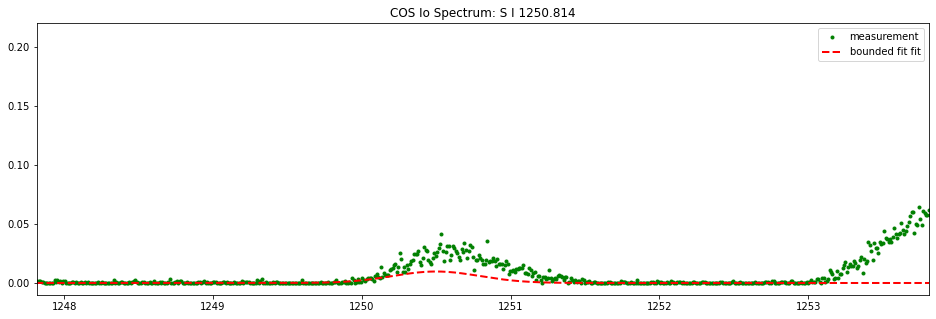

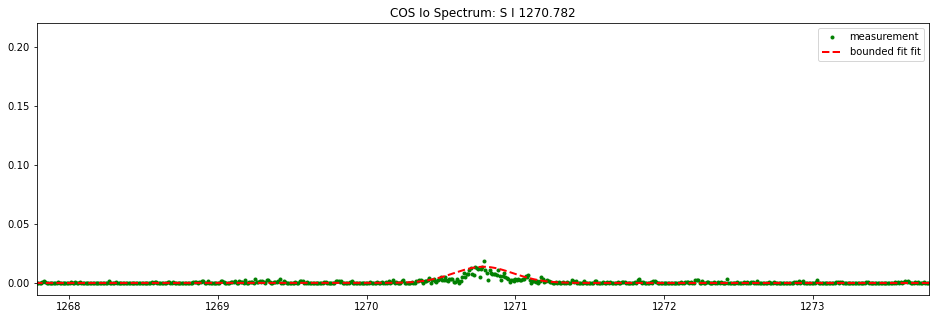

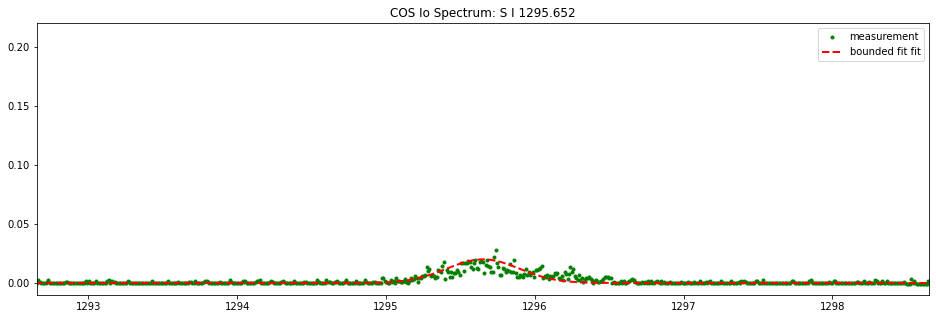

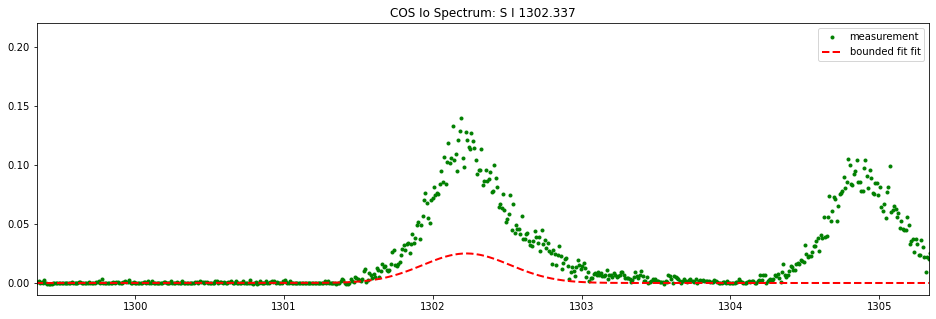

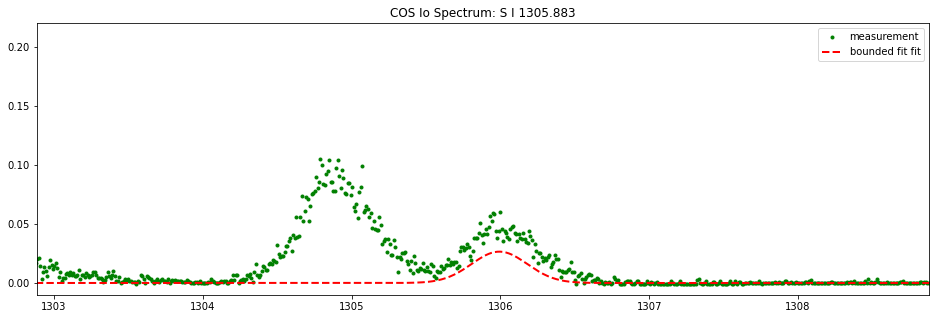

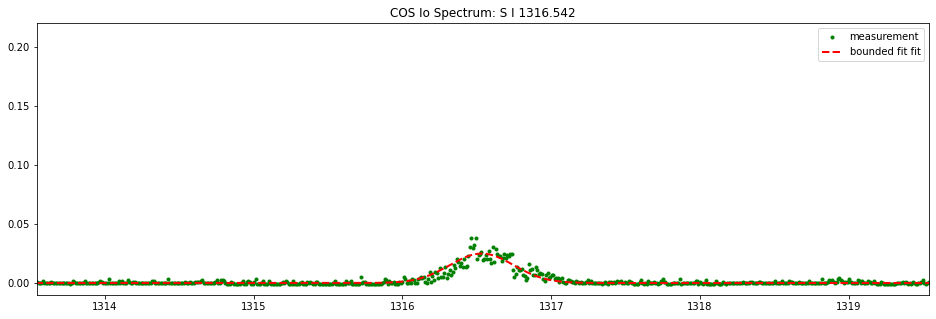

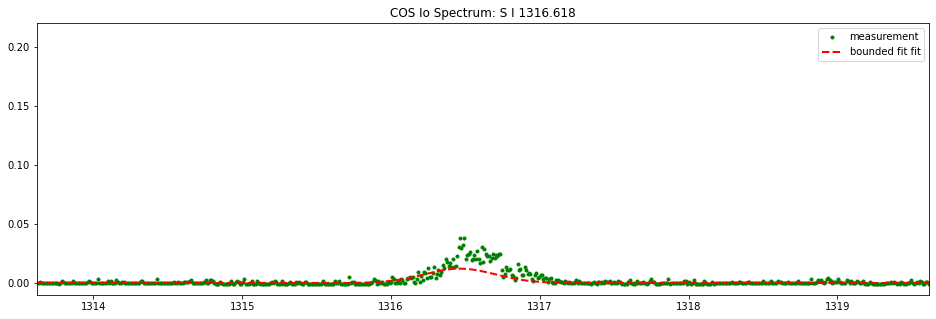

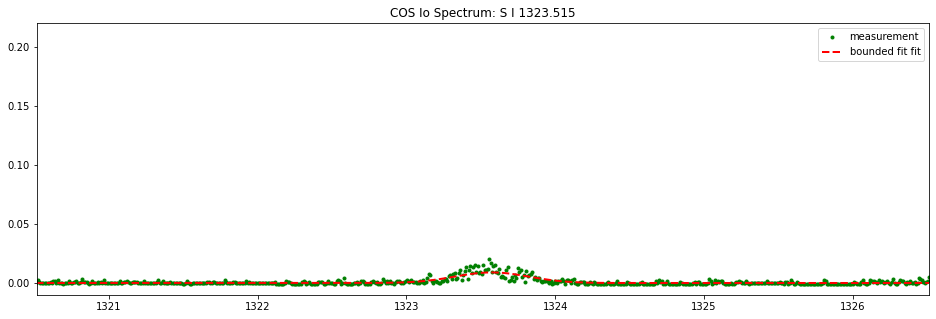

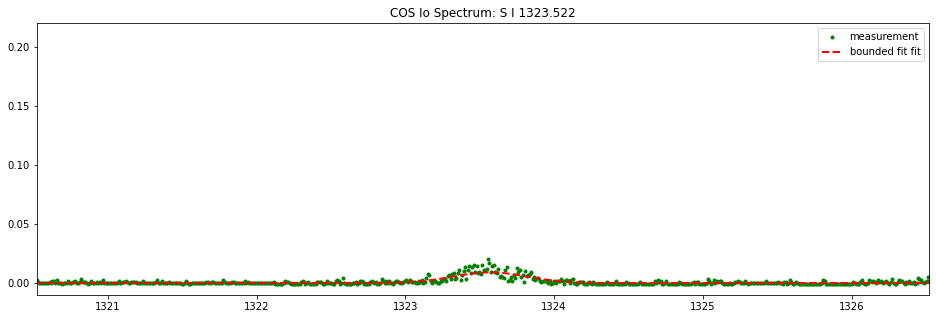

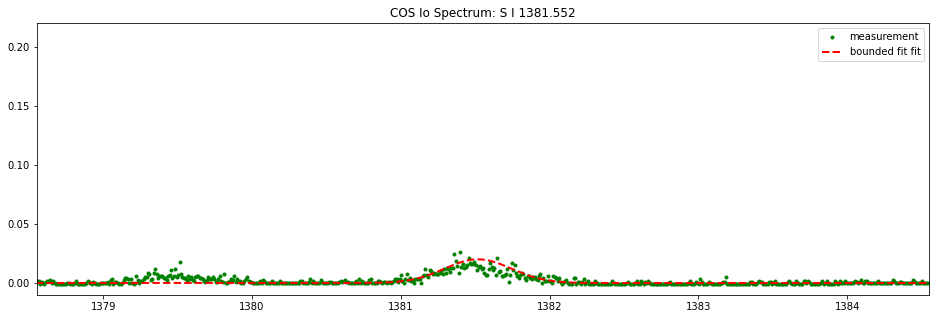

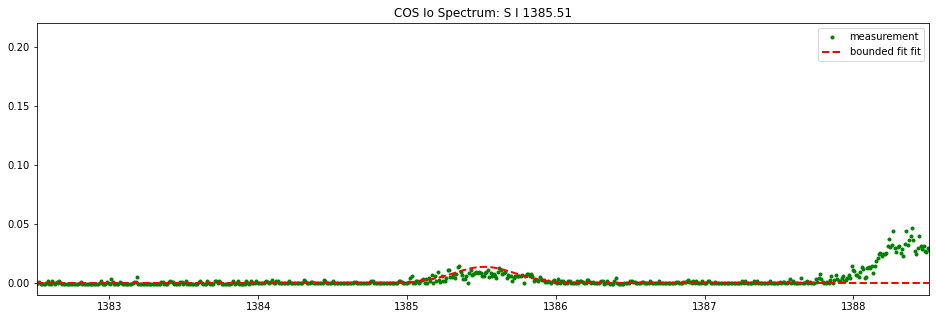

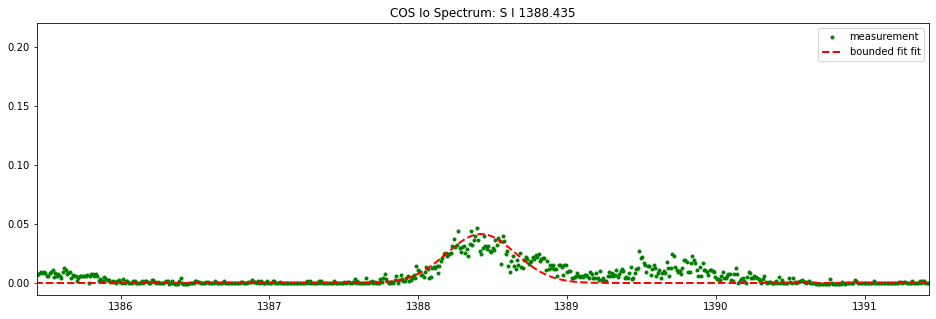

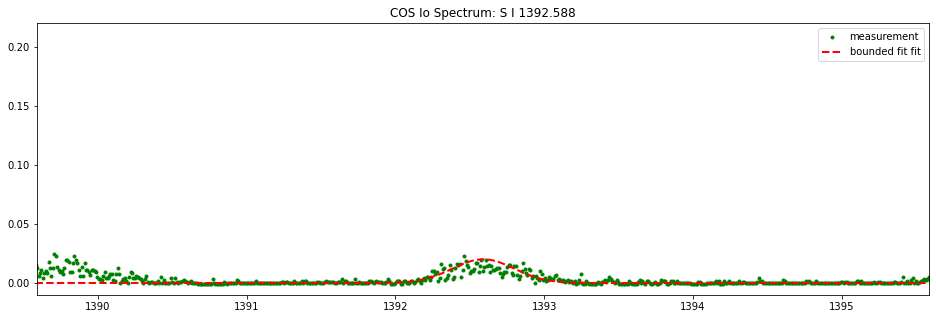

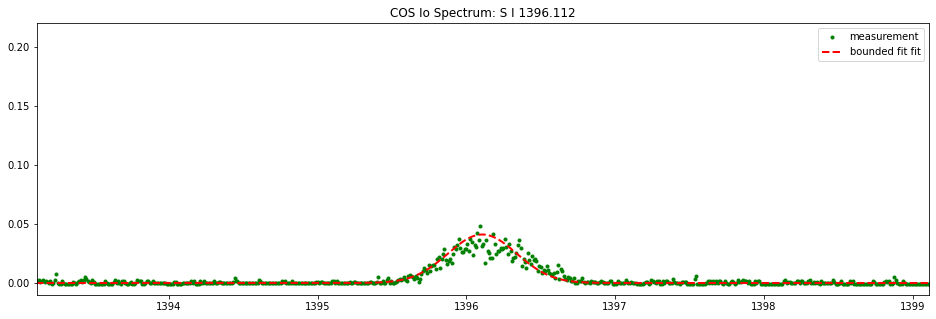

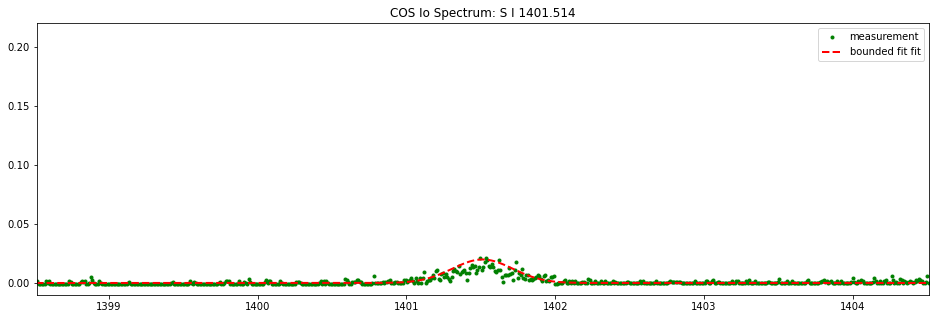

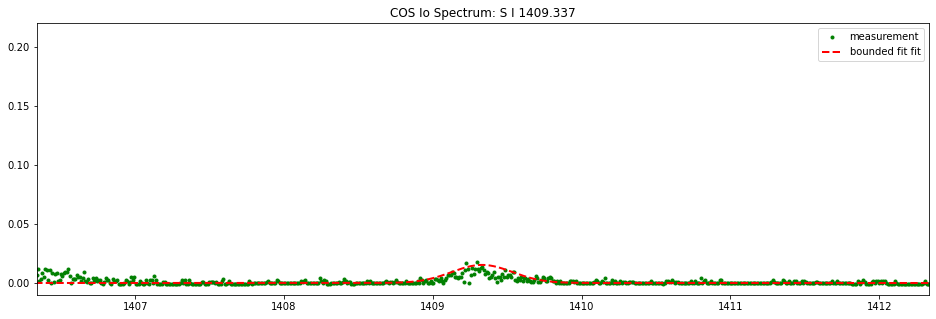

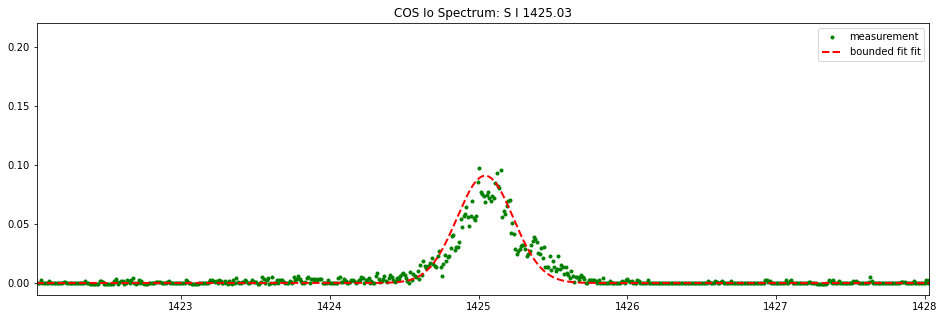

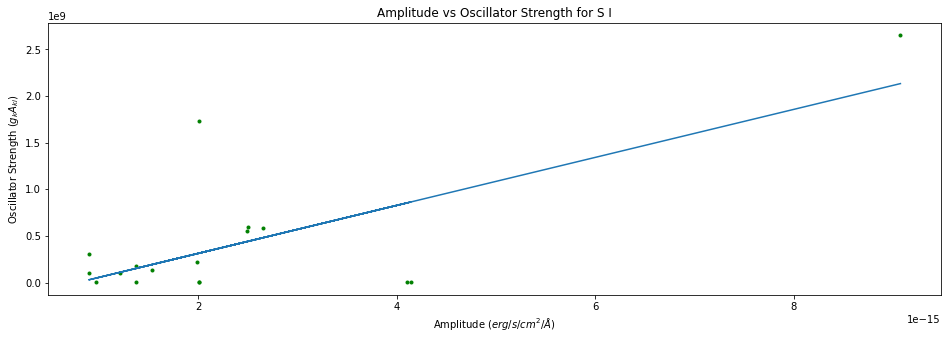

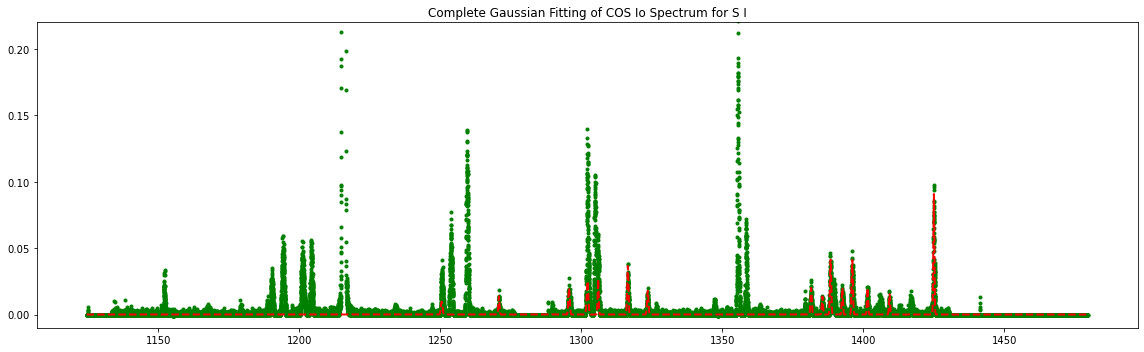

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 15.30it/s]


<Figure size 432x288 with 0 Axes>

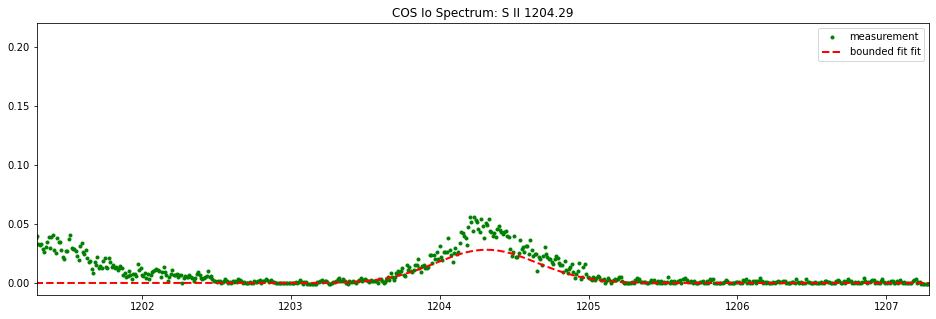

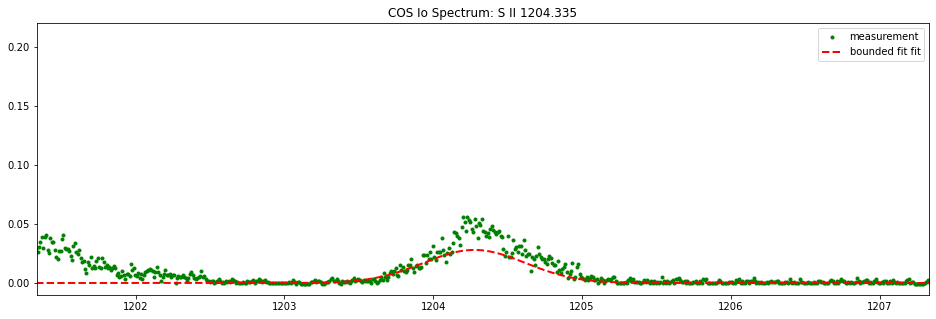

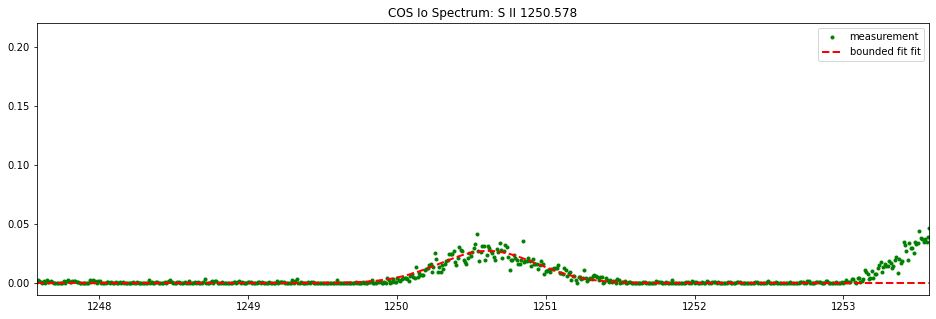

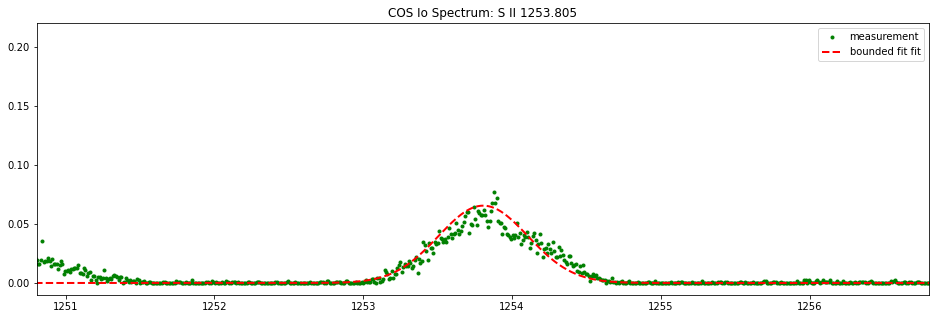

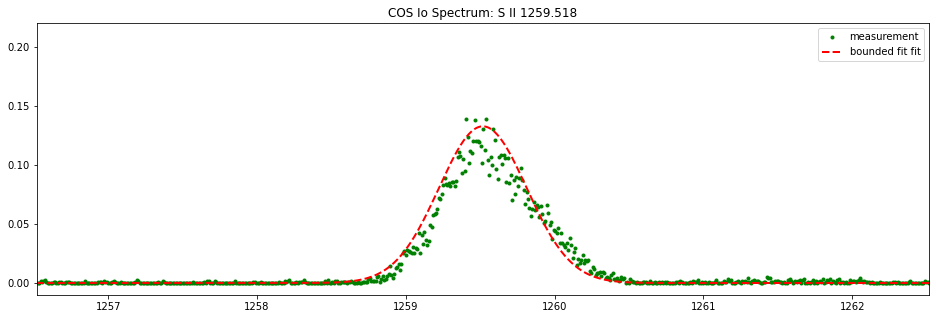

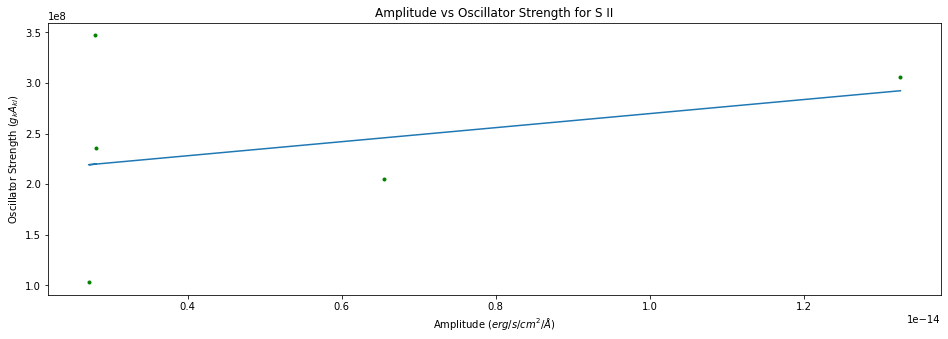

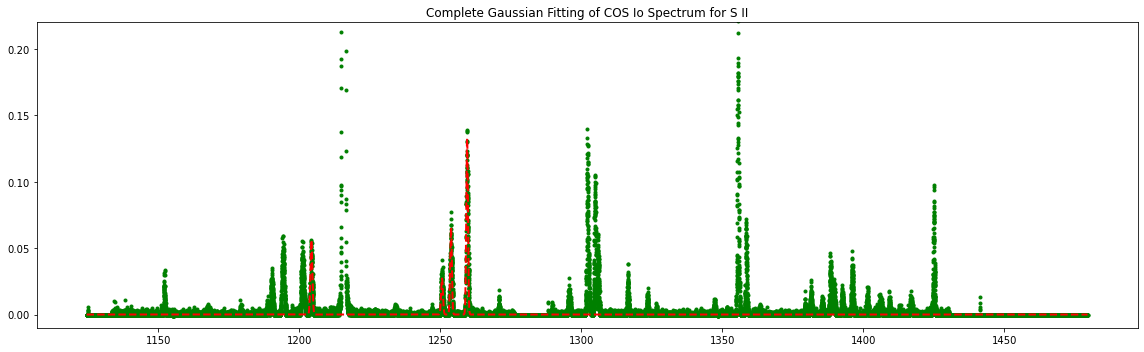

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 15.45it/s]


<Figure size 432x288 with 0 Axes>

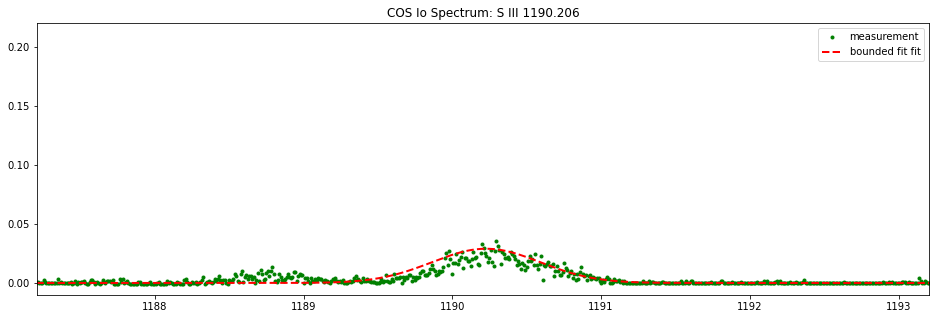

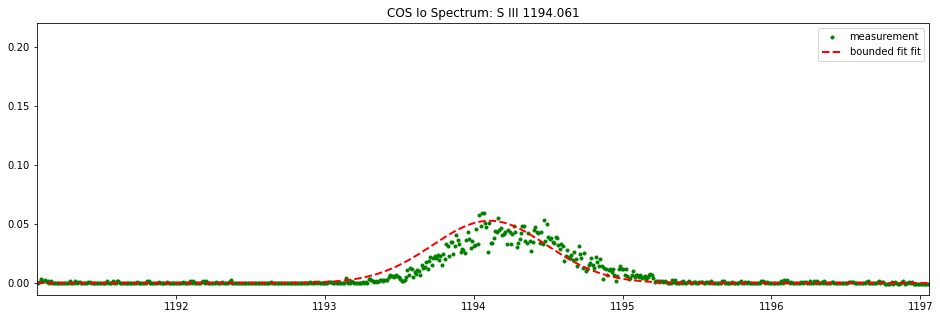

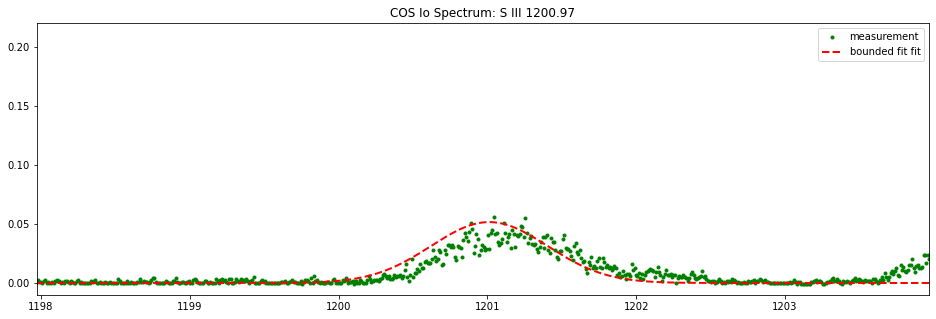

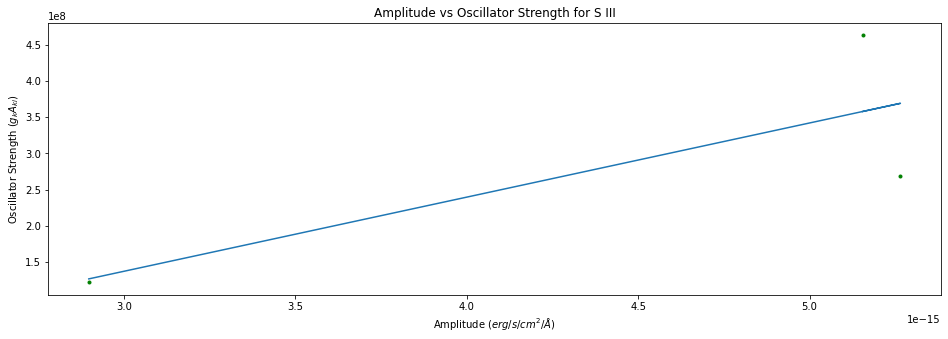

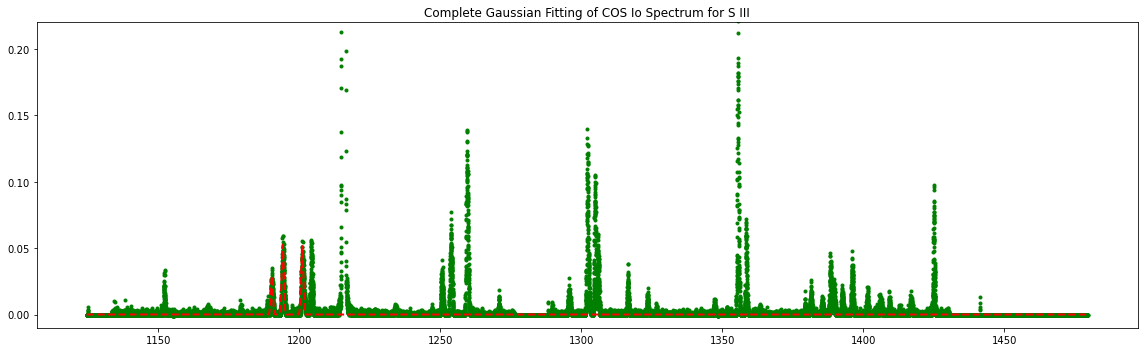

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 15.39it/s]


<Figure size 432x288 with 0 Axes>

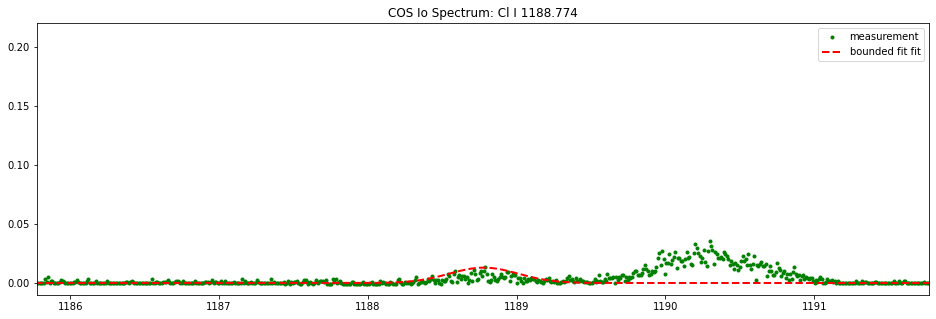

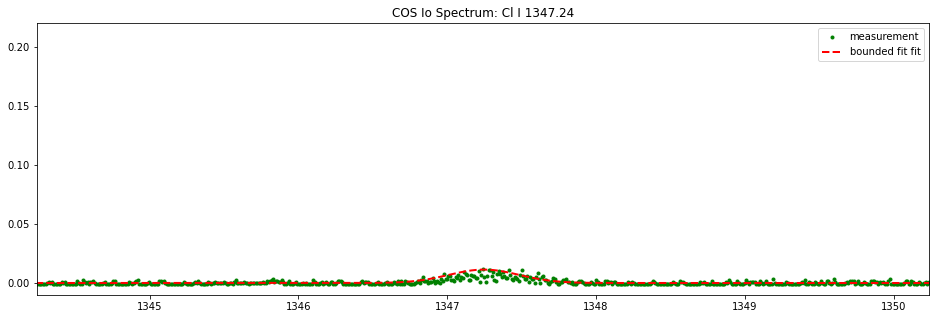

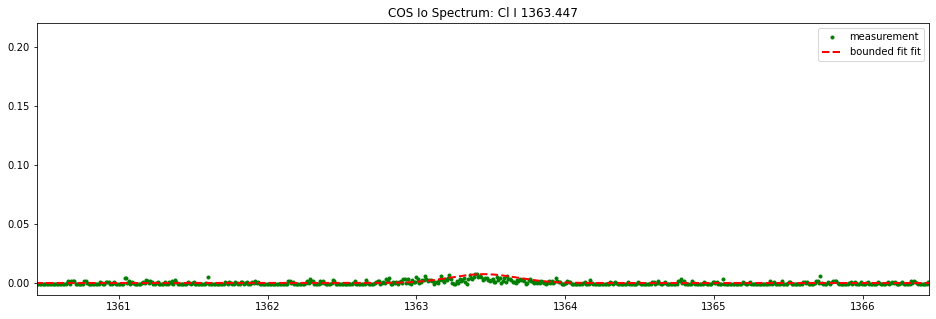

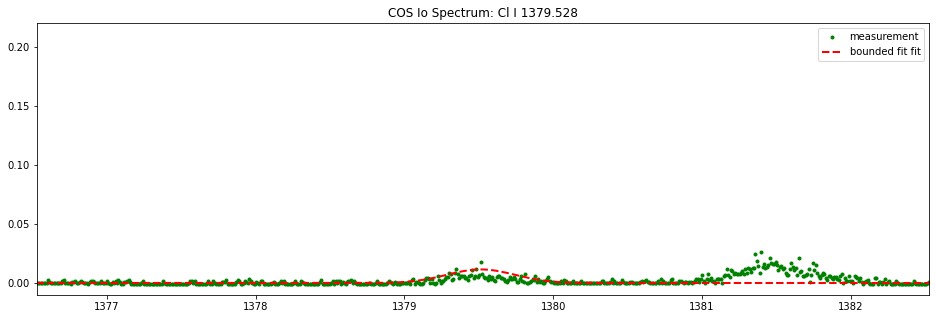

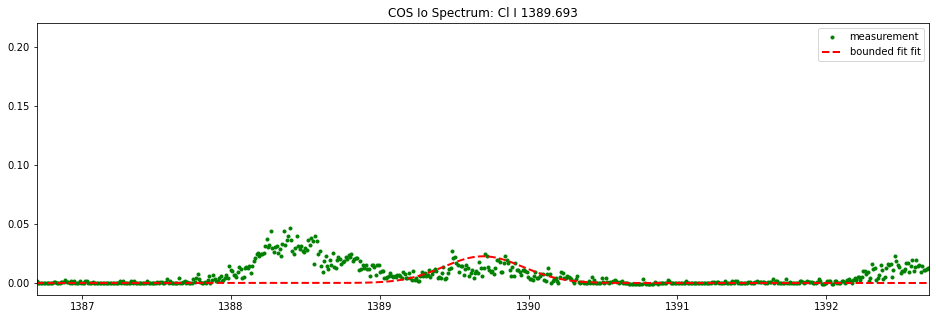

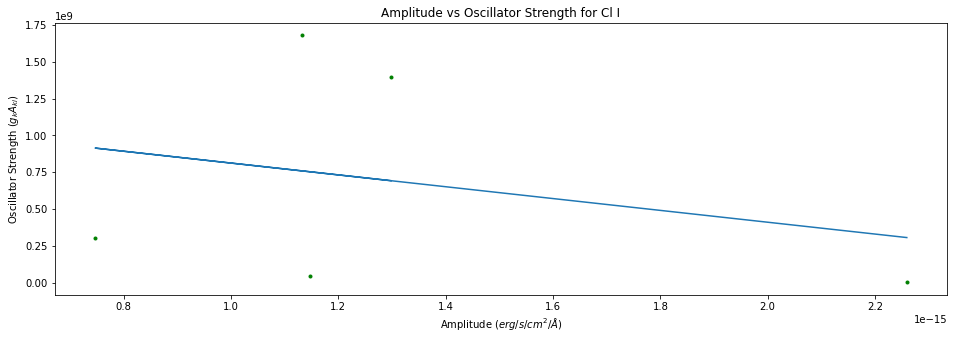

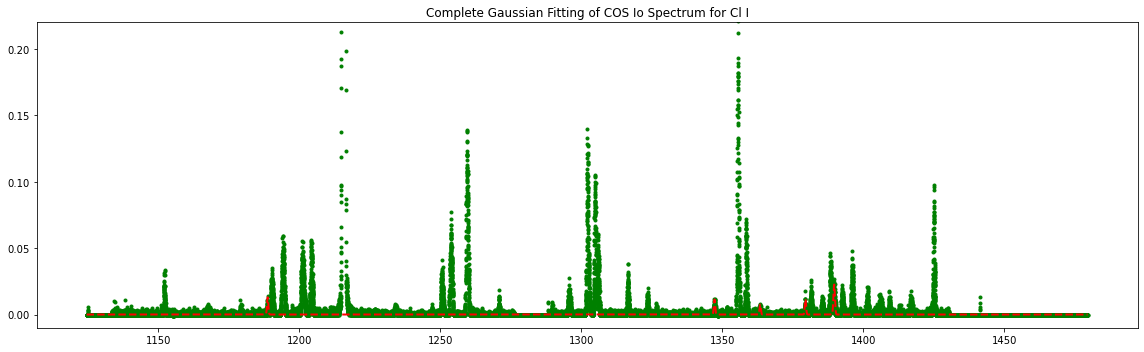

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 14.00it/s]


<Figure size 432x288 with 0 Axes>

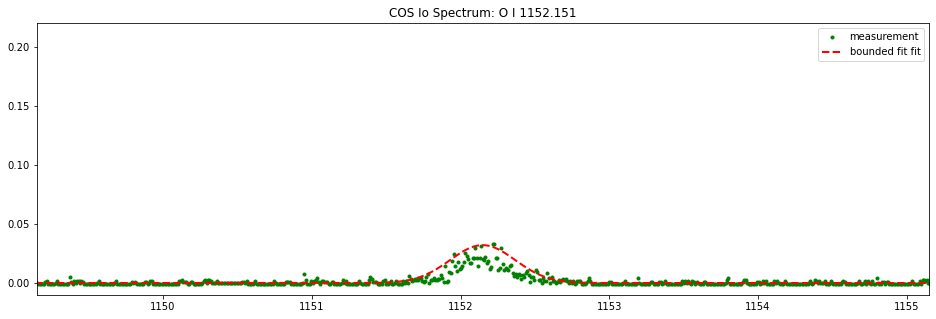

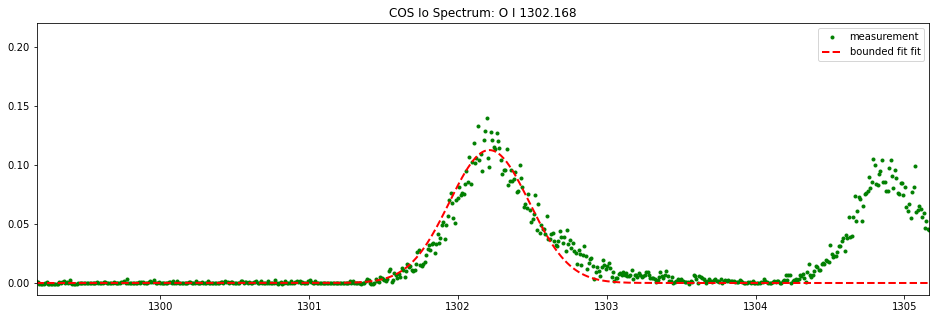

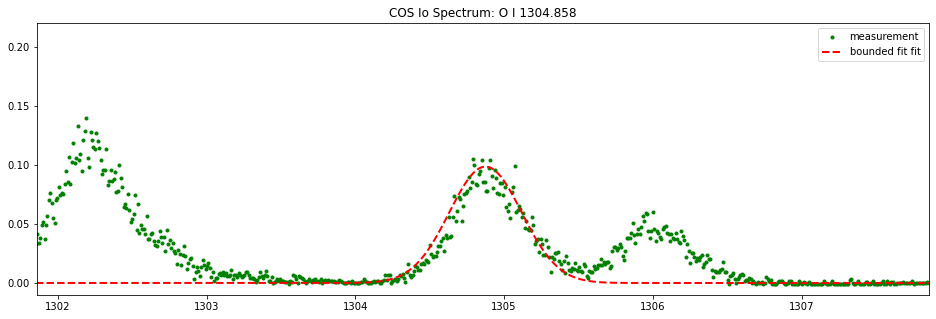

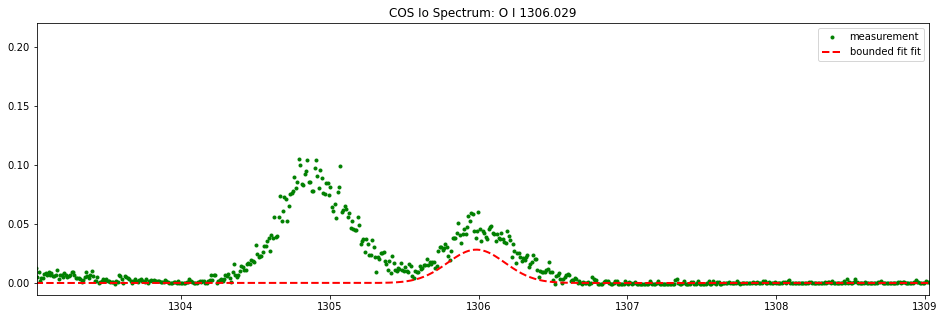

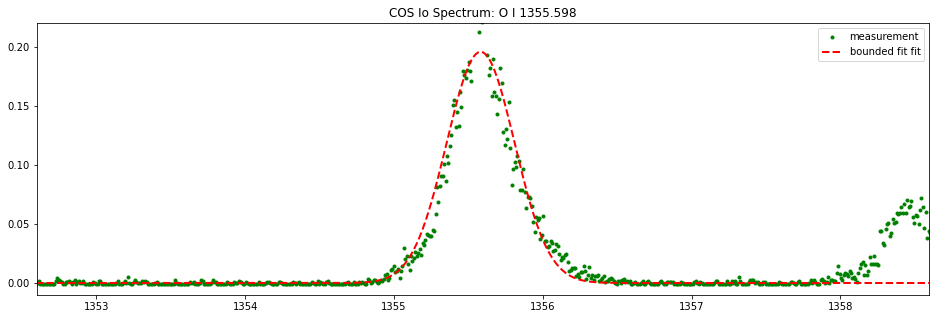

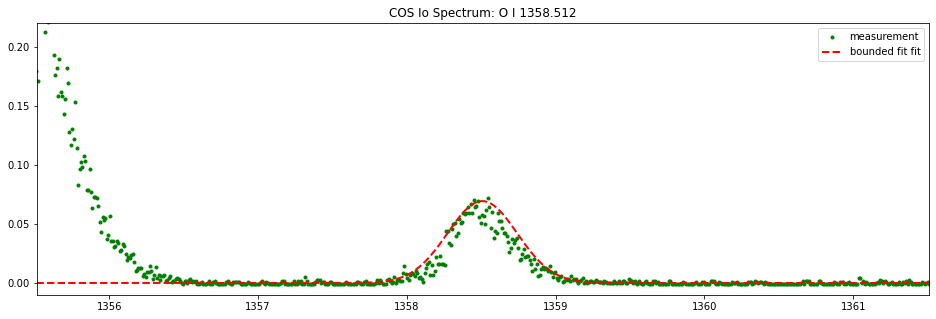

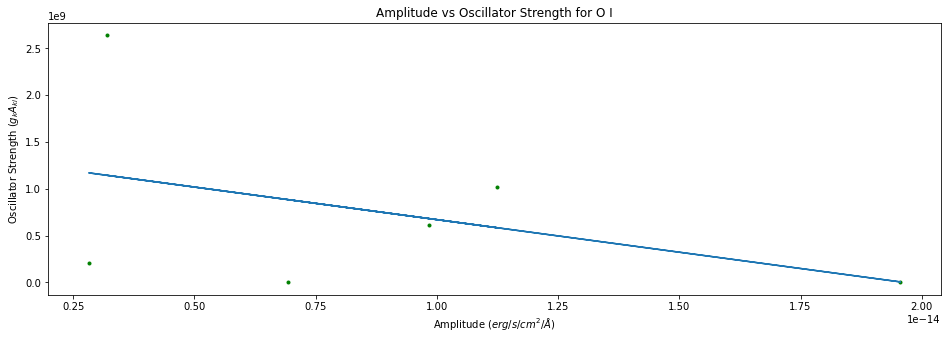

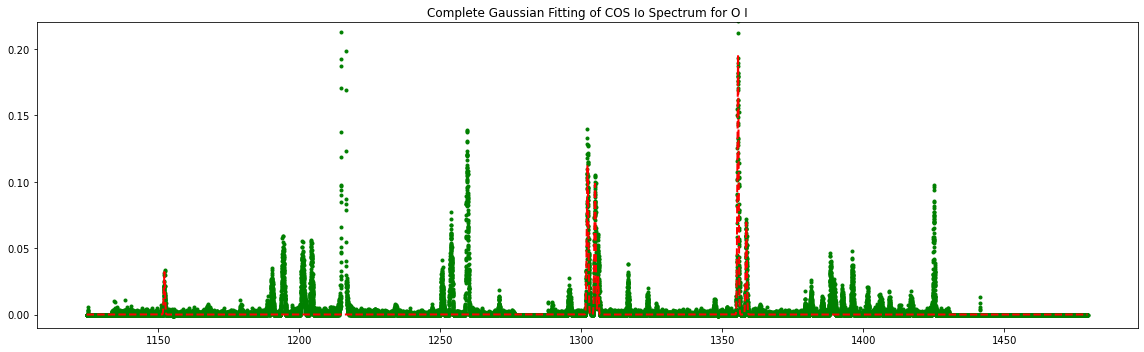

<Figure size 432x288 with 0 Axes>

In [15]:
%matplotlib inline
for i in range(0,len(lines)):
    line = lines[i]
    test,array_line = target_array(line)
    params = fit_whole_spectra(test)
    species_plot(line)
    full_plot_per_species()
    total_params = np.vstack((total_params,params))
    length = np.vstack((length,int(len(params))))

<IPython.core.display.Javascript object>


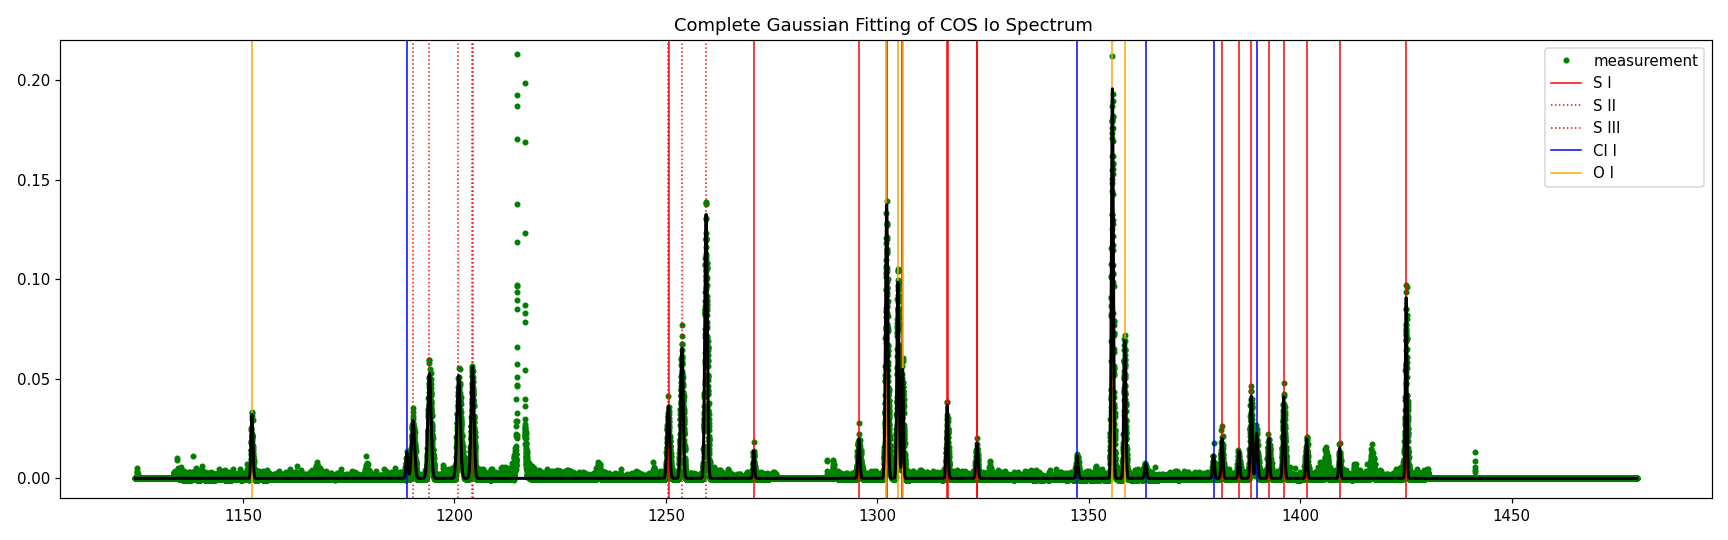

In [16]:
%matplotlib notebook
import matplotlib.pyplot as plt
total_spectrum_plot(total_params, c='black')
plt.show()
save_place = '/Users/jojoa/GitHub/io_brightness/data/figures/total_gauss/'

<IPython.core.display.Javascript object>


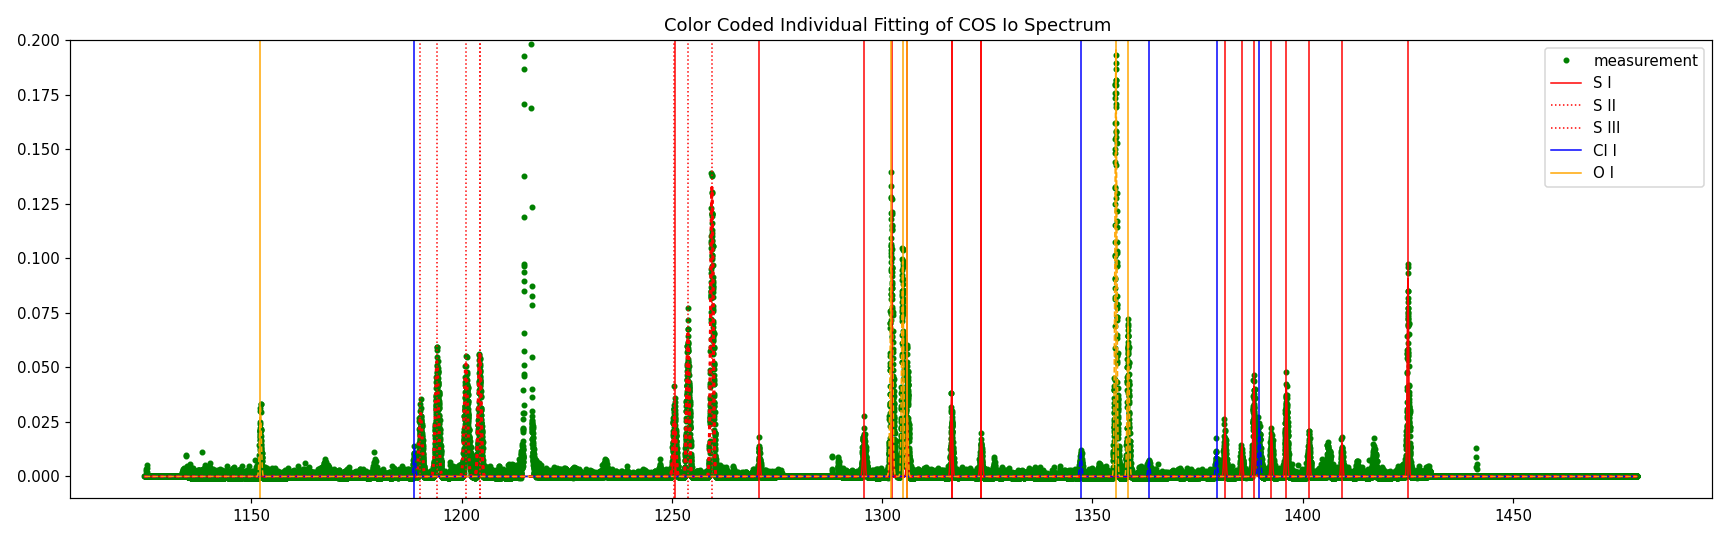

In [17]:
df_wavelength = array['Wavelength']
color_change(total_params)

In [18]:
b = brightness(total_params)

<IPython.core.display.Javascript object>


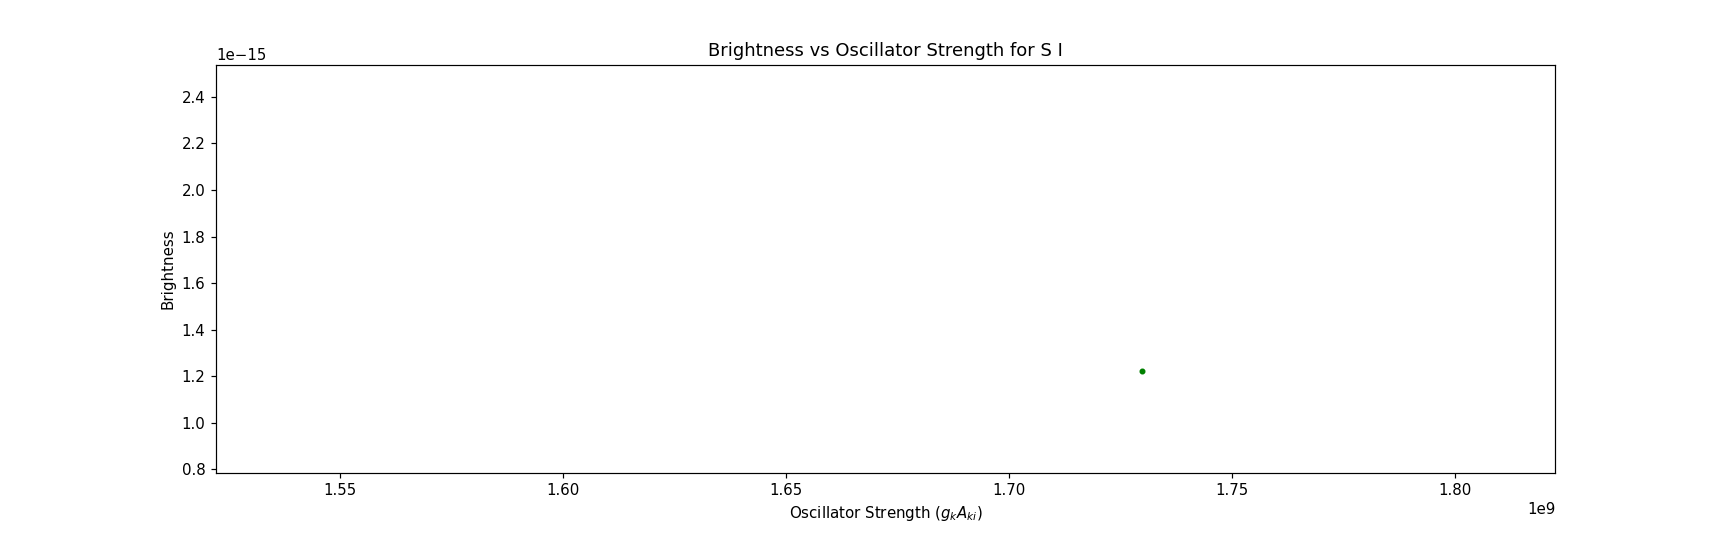

<IPython.core.display.Javascript object>


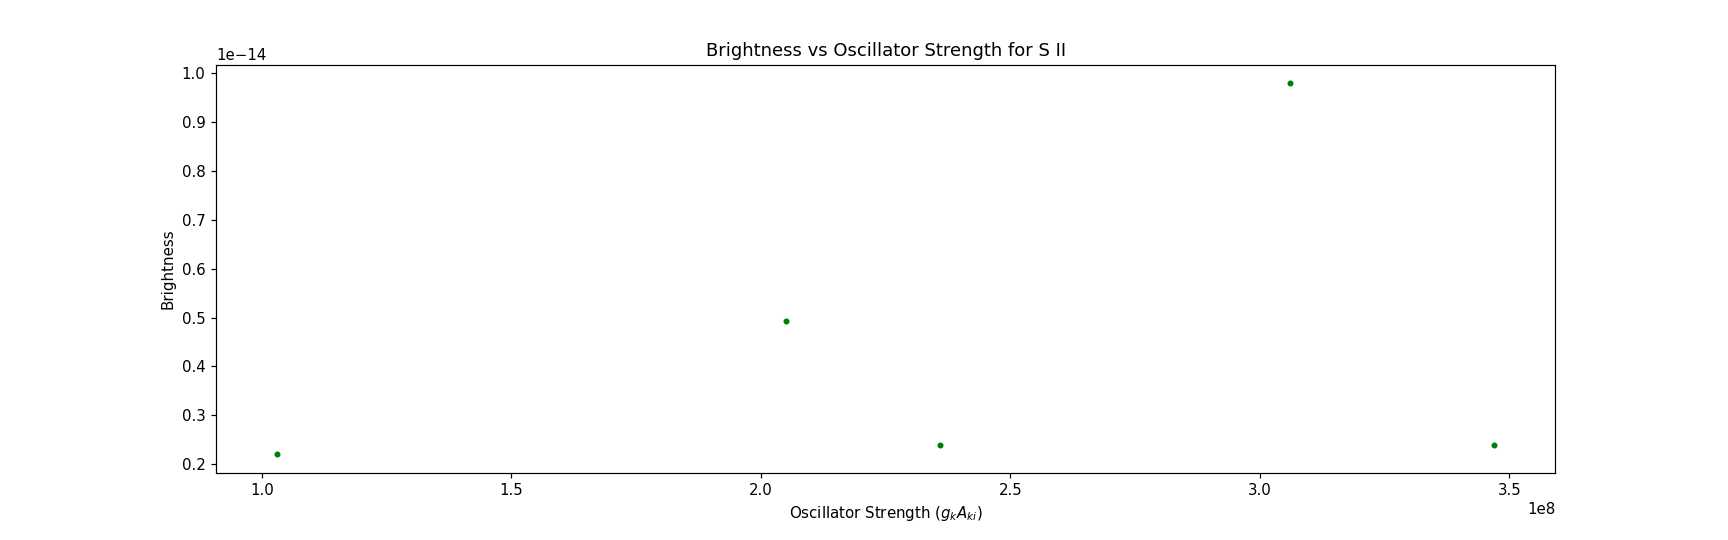

<IPython.core.display.Javascript object>


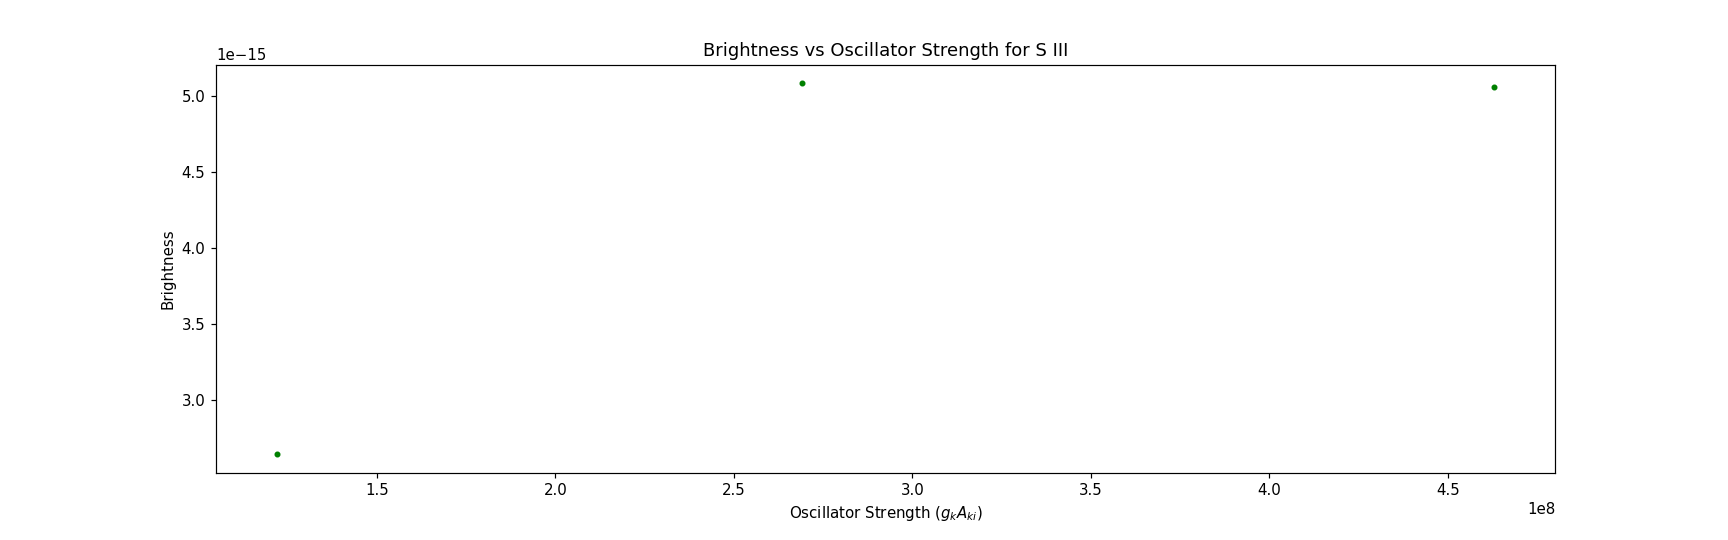

<IPython.core.display.Javascript object>


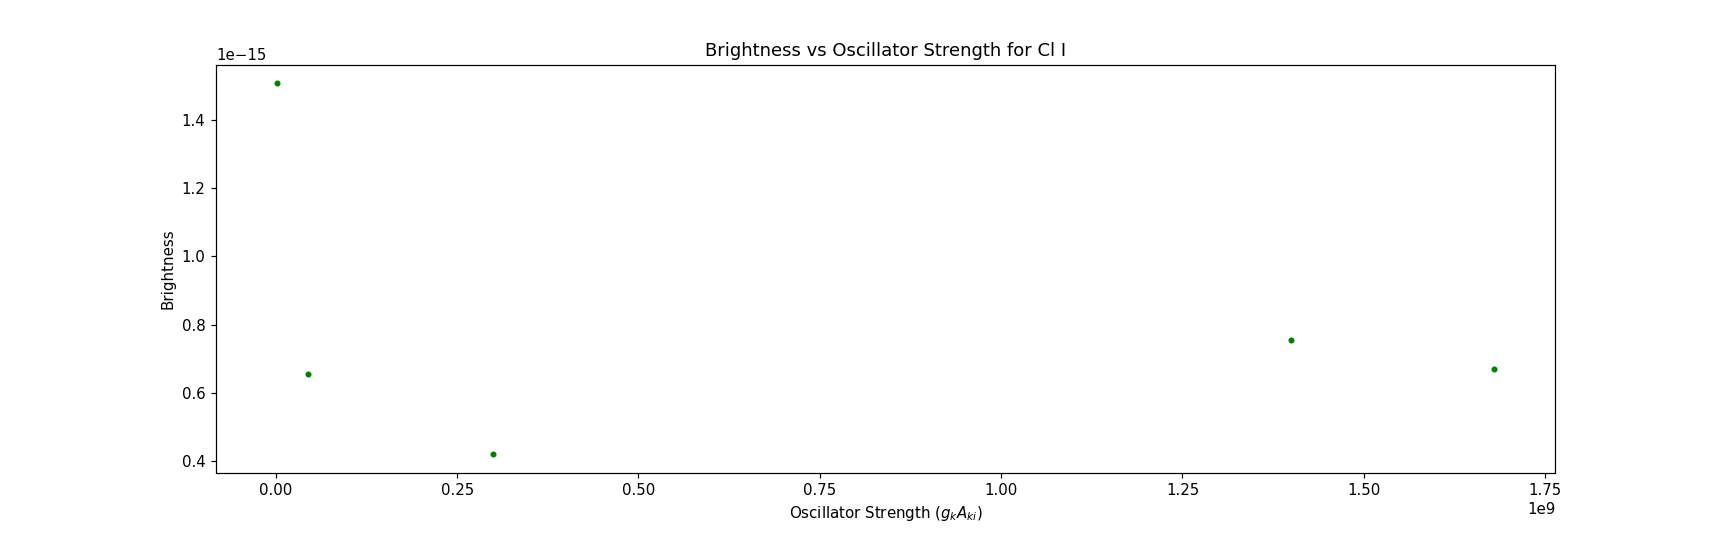

<IPython.core.display.Javascript object>


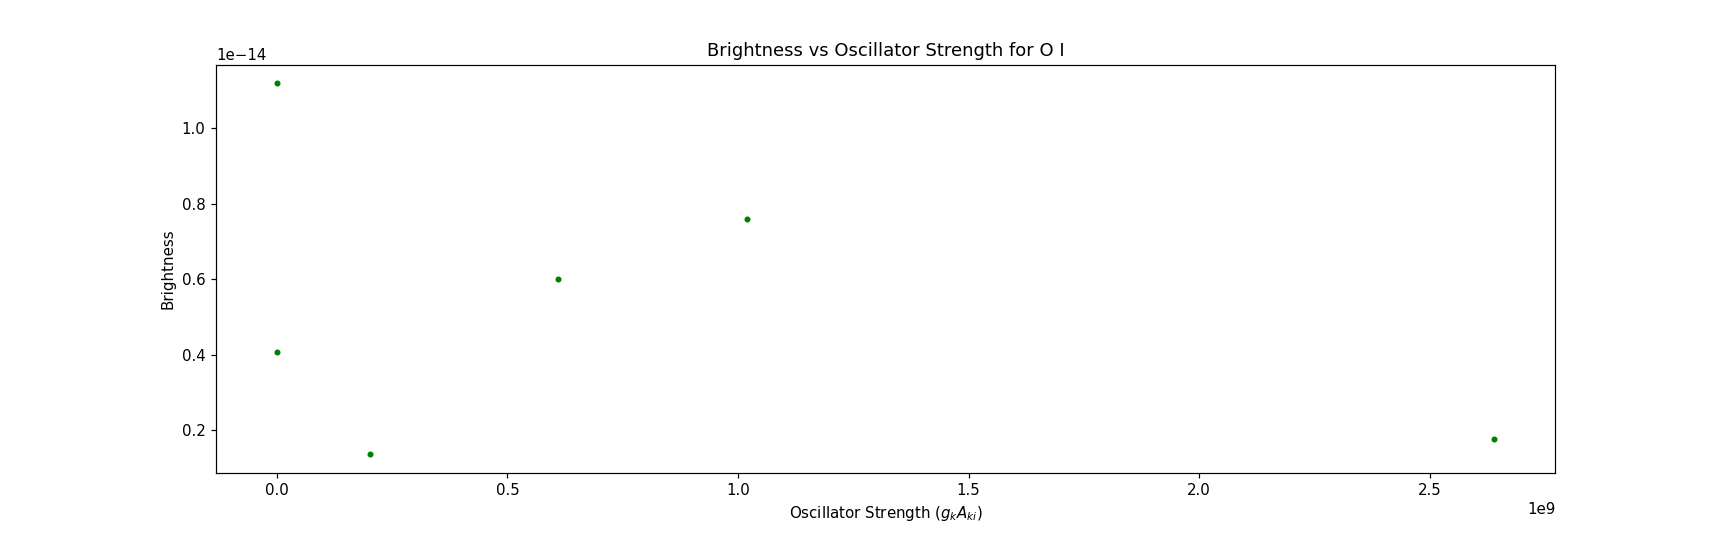

In [19]:
%matplotlib notebook
for i in range(0,len(lines)):
    line = lines[i]
    brightness = b[i]
    test,array_line = target_array(line)
    os = array_line['Oscillator Strength (gA)']
    os_vs_brightness(os,brightness)
    #mean[i] = np.mean(brightness)

<IPython.core.display.Javascript object>


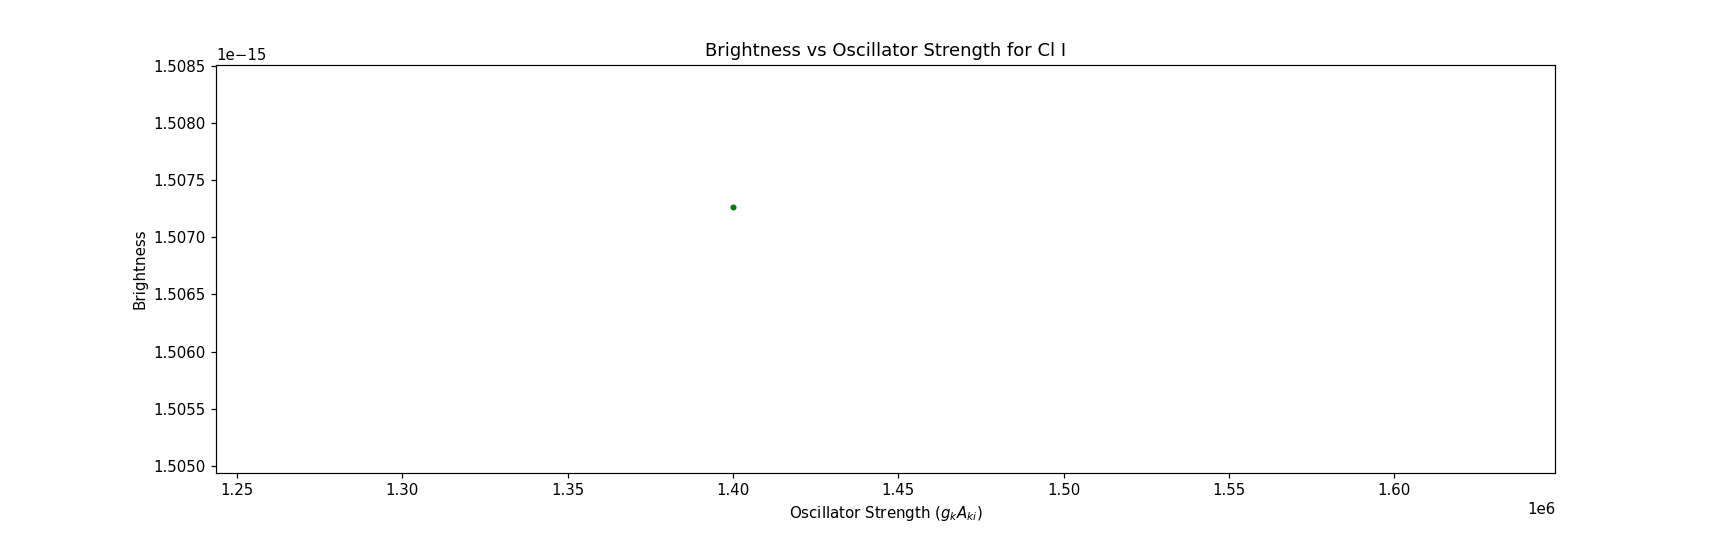

In [20]:
i = 3
line = lines[i]
brightness = b[i]
test,array_line = target_array(line)
os = array_line['Oscillator Strength (gA)']
os_vs_brightness(os,brightness)

In [24]:
b

[array([7.13033467e-16, 6.80941156e-16, 1.22306472e-15, 1.84594571e-15,
        1.24126879e-15, 1.34020141e-15, 7.20105884e-16, 5.54566378e-16,
        5.56071623e-16, 1.12799922e-15, 7.05697992e-16, 2.40338001e-15,
        1.04303118e-15, 2.37823630e-15, 1.01315897e-15, 7.80794372e-16,
        4.30415267e-15]),
 array([2.39881501e-15, 2.40148022e-15, 2.20927910e-15, 4.92736584e-15,
        9.79671151e-15]),
 array([2.64387369e-15, 5.08222137e-15, 5.06012497e-15]),
 array([7.54970912e-16, 6.71087502e-16, 4.21336981e-16, 6.54937286e-16,
        1.50726761e-15]),
 array([1.75628685e-15, 7.58071460e-15, 6.00546336e-15, 1.36366347e-15,
        1.11903393e-14, 4.07288827e-15])]

In [22]:
os

1     1.400000e+09
22    1.680000e+09
25    4.400000e+07
29    1.400000e+06
Name: Oscillator Strength (gA), dtype: float64

In [25]:
amp = 0.03*10**-13
sigma = 0.26
((2*np.pi)**.5)*(amp*sigma)

1.95517005421218e-15

In [25]:
test,array=target_array(line='S I')

In [26]:
array

,Wavelength,Species,Width,Oscillator Strength (A),Oscillator Strength (gA),Guess A,Amplitude Divided,Amplitude,Blended?,Lifetime,Notes
8,1250.814,S I,0.23,2660000.0,7.980000e+06,0.0010,0.00,2.620000e-17,Yes / w S II,2.66E+06,NaN
11,1270.782,S I,0.23,25400000.0,1.780000e+08,0.0175,0.01,5.840000e-16,No,2.54E+07,NaN
12,1295.652,S I,0.25,346000000.0,1.730000e+09,0.0250,0.06,5.670000e-15,Yes / w Self,3.46E+08,NaN
14,1302.337,S I,0.20,120000000.0,6.000000e+08,0.0050,0.02,1.970000e-15,Yes / w O I,1.20E+08,NaN
16,1305.883,S I,0.15,196000000.0,5.880000e+08,0.0200,0.02,1.930000e-15,Yes / w O I,1.96E+08,NaN
18,1316.542,S I,0.20,78900000.0,5.520000e+08,0.0200,0.02,1.810000e-15,Yes / w Self,7.89E+07,NaN
19,1316.618,S I,0.20,21000000.0,1.050000e+08,0.0050,0.00,3.440000e-16,Yes / w Self,2.10E+07,NaN
20,1323.515,S I,0.23,60400000.0,3.020000e+08,0.0050,0.01,9.910000e-16,Yes / w Self,6.04E+07,A/B detector edge effect near 1321
21,1323.522,S I,0.23,34000000.0,1.020000e+08,0.0050,0.00,3.350000e-16,Yes / w Self,3.40E+07,NaN
27,1381.552,S I,0.23,542000.0,1.630000e+06,0.0250,0.00,5.350000e-18,No,5.42E+05,NaN
